# Explore the Vital Dynamics Mortality Components

In [1]:
import numpy as np

from laser.generic.newutils import grid
from laser.core import PropertySet
from laser.generic.newutils import ValuesMap
from laser.generic import Model
from laser.generic import SEIR
import laser.core.distributions as dists
from laser.generic.vitaldynamics import MortalityByCDR

from laser.core import __version__ as laser_core_version
from laser.generic import __version__ as laser_generic_version
print(f"LASER version: {laser_core_version}")
print(f"LASER Generic version: {laser_generic_version}")


LASER version: 0.7.0
LASER Generic version: 0.0.0


## MortalityByCDR

First, we will look at `MortalityByCDR`.

In [2]:
ROWS = 1
COLS = 1
NNODES = ROWS * COLS
NTICKS = 3650
CDR = 20.0  # Crude Mortality Rate 20.0 per 1000 per year

scenario = grid(M=ROWS, N=COLS, population_fn=lambda i, j: 100_000)
# scenario["S"] = scenario.population
scenario["E"] = (scenario.population * 0.125).astype(np.int32)
scenario["I"] = (scenario.population * 0.125).astype(np.int32)
scenario["R"] = (scenario.population * 0.375).astype(np.int32)
scenario["S"] = (scenario.population - (scenario.E + scenario.I + scenario.R)).astype(np.int32)
parameters = PropertySet({"nticks": NTICKS})
mortalityrates = ValuesMap.from_scalar(CDR, NNODES, NTICKS).values

expdurdist = dists.normal(loc=30.0, scale=3.0)
infdurdist = dists.normal(loc=30.0, scale=5.0)


### Single Single Node Simulation


In [3]:
from datetime import datetime

parameters |= {"prng_seed": datetime.now().microsecond}
print(f"PRNG Seed: {parameters['prng_seed']}")
model = Model(scenario, parameters, birthrates=None)

model.components = [
    SEIR.Susceptible(model),
    SEIR.Exposed(model, expdurdist, infdurdist),
    SEIR.Infectious(model, infdurdist),
    SEIR.Recovered(model),
    # BirthsByCBR(model, birthrates, pyramid),
    MortalityByCDR(model, mortalityrates),
]

pop_start = model.people.count
print(f"At t=0    {model.people.count = :,}")
model.run()
pop_finish = model.people.count
print(f"At t={model.params.nticks} {model.people.count = :,}")


PRNG Seed: 382644
At t=0    model.people.count = 100,000


100,000 agents in 1 node(s): 100%|██████████| 3650/3650 [00:01<00:00, 1835.78it/s]

At t=3650 model.people.count = 100,000


### Plot Population Over Time


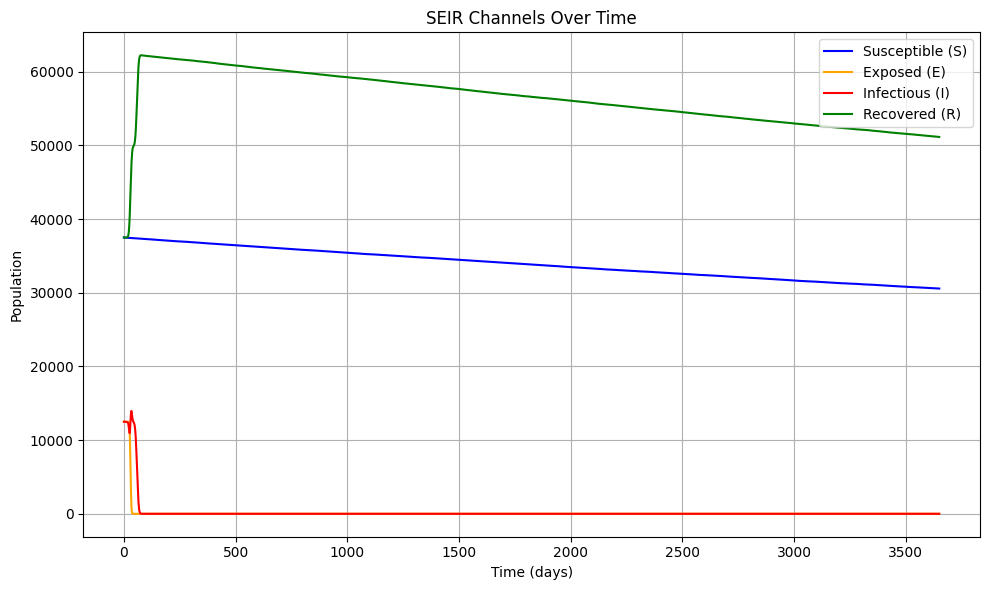

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(model.nodes.S[:,0], label="Susceptible (S)", color="blue")
plt.plot(model.nodes.E[:,0], label="Exposed (E)", color="orange")
plt.plot(model.nodes.I[:,0], label="Infectious (I)", color="red")
plt.plot(model.nodes.R[:,0], label="Recovered (R)", color="green")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("SEIR Channels Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Check Statistics


In [ ]:
from laser.generic.shared import State

print(f"{(model.people.state != State.DECEASED.value).sum() = :,}")
print(f"{(model.nodes.S + model.nodes.E + model.nodes.I + model.nodes.R)[-1] =}")
N = model.nodes.S + model.nodes.E + model.nodes.I + model.nodes.R
starts = np.array(range(0, NTICKS, 365), dtype=np.int32)
ends = starts + 364
mortality = (1000 * (N[starts] - N[ends]) / N[starts]).mean(axis=0)[0]
# print(f"{mortality.shape = }")
print(f"{mortality = } (c.f. CDR={CDR})")

(model.people.state != State.DECEASED.value).sum() = 81,721
(model.nodes.S + model.nodes.E + model.nodes.I + model.nodes.R)[-1] =array([81721], dtype=int32)
mortality = np.float64(19.94277635740726)


### Multiple Single Node Simulations with Varying CDR

Let's run the model several times over different CDR values and plot the results.

We'll run 11 times each with 100_000 population and CDR values in [2, 10, 20, 40] and plot the histogram of CDR and mean for each CDR.

In [6]:
cdr_values = [2, 10, 20, 40]
n_runs = 11
results = {}

for cdr in cdr_values:
    run_mortalities = []
    for index in range(n_runs):
        # Set up scenario and parameters for each run
        scenario = grid(M=ROWS, N=COLS, population_fn=lambda i, j: 100_000)
        scenario["E"] = (scenario.population * 0.125).astype(np.int32)
        scenario["I"] = (scenario.population * 0.125).astype(np.int32)
        scenario["R"] = (scenario.population * 0.375).astype(np.int32)
        scenario["S"] = (scenario.population - (scenario.E + scenario.I + scenario.R)).astype(np.int32)
        parameters_run = PropertySet({"nticks": NTICKS, "prng_seed": np.random.randint(0, 1_000_000)})
        mortalityrates_run = ValuesMap.from_scalar(cdr, NNODES, NTICKS).values

        model_run = Model(scenario, parameters_run, birthrates=None)
        model_run.components = [
            SEIR.Susceptible(model_run),
            SEIR.Exposed(model_run, expdurdist, infdurdist),
            SEIR.Infectious(model_run, infdurdist),
            SEIR.Recovered(model_run),
            MortalityByCDR(model_run, mortalityrates_run),
        ]
        model_run.run(f"CDR {cdr:2} Run {index+1:02}/{n_runs:02}")
        N_run = model_run.nodes.S + model_run.nodes.E + model_run.nodes.I + model_run.nodes.R
        starts_run = np.array(range(0, NTICKS, 365), dtype=np.int32)
        ends_run = starts_run + 364
        mortality_run = (1000 * (N_run[starts_run] - N_run[ends_run]) / N_run[starts_run]).mean(axis=0)[0]
        run_mortalities.append(mortality_run)
    results[cdr] = run_mortalities



CDR 40 Run 11/11: 100%|██████████| 3650/3650 [00:01<00:00, 2266.88it/s]


### Plot Results


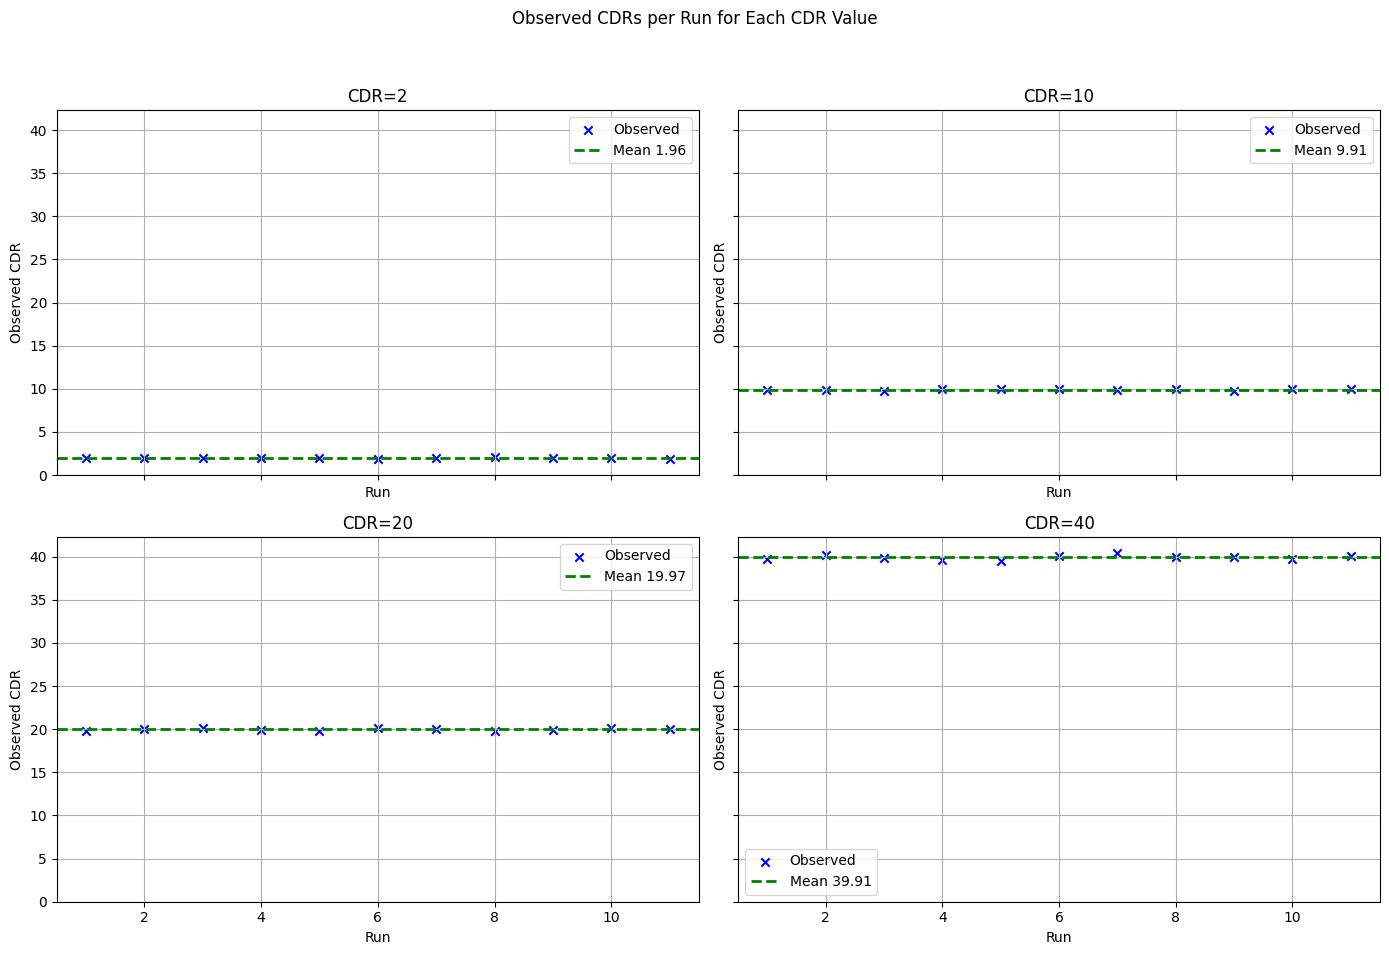

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

for idx, cdr in enumerate(cdr_values):
    ax = axes[idx]
    mortalities = results[cdr]
    ax.scatter(range(1, n_runs + 1), mortalities, color="blue", marker="x", label="Observed")
    ax.axhline(np.mean(mortalities), color="green", linestyle="--", linewidth=2, label=f"Mean {np.mean(mortalities):.2f}")
    ax.set_title(f"CDR={cdr}")
    ax.set_xlabel("Run")
    ax.set_ylabel("Observed CDR")
    ax.grid(True)
    ax.legend()

plt.suptitle("Observed CDRs per Run for Each CDR Value")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## MortalityByEstimator

Next, we will look at `MortalityByEstimator` which draws date-of-death (`dod`) from an estimator and expires agents at that DOD.

We will need a population pyramid (`AliasedDistribution`) to initialize the population ages (`dob`). We will also need a survival curve (`KaplanMeierEstimator`) to estimate the DOD.

The data for the `AliasedDistribution` is simple the number of samples in each implied bucket. E.g., the values [125, 500, 125, 250] imply four buckets with 1/8<sup>th</sup> of the population in the first, 1/2 in the second, 1/8<sup>th</sup> in the third, and the remainder, 1/4<sup>th</sup>, in the last.

The data for the `KaplanMeierEstimator` is the cumulative number of deaths up to and including each implied age bin/bucket. E.g., the values [7470, 1059, 1003, 950, 892] for ages 0 ... 4 in the Nigeria 2020 survival information indicate the number of deaths at each age. The input to the estimator would be [7470, 8529, 9532, 10482, 892].


In [8]:
from laser.core.demographics import AliasedDistribution
from laser.core.demographics import KaplanMeierEstimator

# https://population.un.org/wpp/downloads?folder=Standard%20Projections&group=Population WPP2024_POP_F01_1_POPULATION_SINGLE_AGE_BOTH_SEXES.xlsx
age_data = np.loadtxt("Nigeria-Distribution-2020.csv", delimiter=",", usecols=0)[0:89]  # Up to age 89 (largest value int16 can hold.)
pyramid = AliasedDistribution(age_data)

# https://population.un.org/wpp/downloads?folder=Standard%20Projections&group=Mortality WPP2024_MORT_F04_1_LIFE_TABLE_SURVIVORS_BOTH_SEXES.xlsx
# Use `.cumsum()` because the KME takes cumulative counts.
survival_data = np.loadtxt("Nigeria-Survival-2020.csv", delimiter=",", usecols=1)[0:89].cumsum() # Up to age 89 (largest value int16 can hold.)
survival = KaplanMeierEstimator(survival_data)


In [ ]:
from laser.generic.vitaldynamics import BirthsByCBR
from laser.generic.vitaldynamics import MortalityByEstimator

parameters |= {"prng_seed": datetime.now().microsecond}
print(f"PRNG Seed: {parameters['prng_seed']}")
model = Model(scenario, parameters, birthrates=None)

model.components = [
    SEIR.Susceptible(model),
    SEIR.Exposed(model, expdurdist, infdurdist),
    SEIR.Infectious(model, infdurdist),
    SEIR.Recovered(model),
    # No births, but we need to track initial population DOBs
    BirthsByCBR(model, birthrates=ValuesMap.from_scalar(0.0, NNODES, NTICKS).values, pyramid=pyramid),
    MortalityByEstimator(model, survival),
]

pop_start = model.people.count
print(f"At t=0    {model.people.count = :,}")
model.run()
pop_finish = model.people.count
print(f"At t={model.params.nticks} {model.people.count = :,}")

PRNG Seed: 172297
At t=0    model.people.count = 100,000


100,000 agents in 1 node(s): 100%|██████████| 3650/3650 [00:01<00:00, 2489.36it/s]

At t=3650 model.people.count = 100,000


### Plot Population Over Time


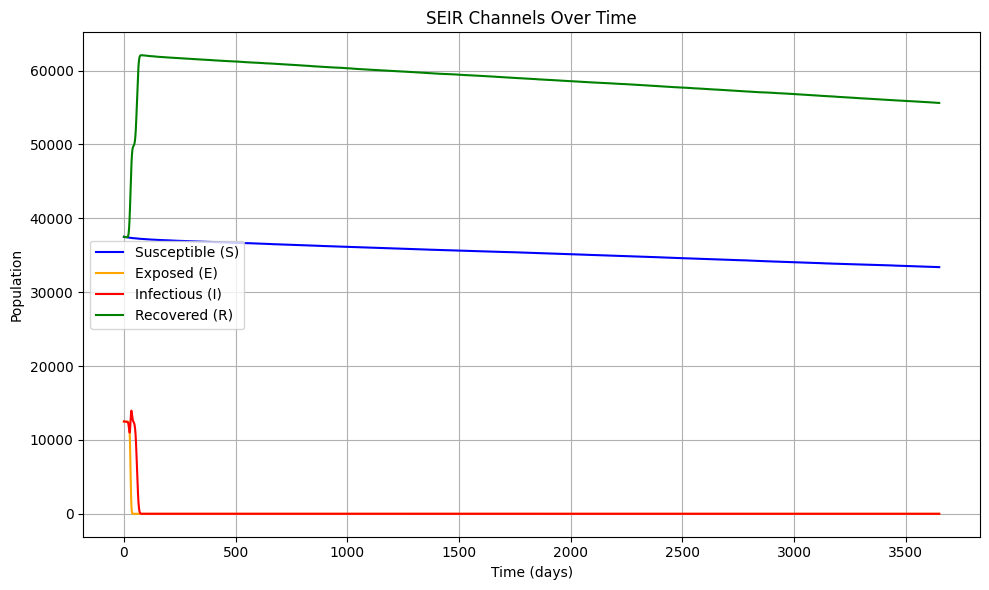

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(model.nodes.S[:,0], label="Susceptible (S)", color="blue")
plt.plot(model.nodes.E[:,0], label="Exposed (E)", color="orange")
plt.plot(model.nodes.I[:,0], label="Infectious (I)", color="red")
plt.plot(model.nodes.R[:,0], label="Recovered (R)", color="green")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("SEIR Channels Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
print(f"{(model.people.state != State.DECEASED.value).sum() = :8,}")
print(f"{(model.nodes.S + model.nodes.E + model.nodes.I + model.nodes.R)[-1] = :}")
N = model.nodes.S + model.nodes.E + model.nodes.I + model.nodes.R
starts = np.array(range(0, NTICKS, 365), dtype=np.int32)
ends = starts + 364
mortality = (1000 * (N[starts] - N[ends]) / N[starts]).mean(axis=0)[0]
# print(f"{mortality.shape = }")
print(f"{mortality = }")


(model.people.state != State.DECEASED.value).sum() =   89,021
(model.nodes.S + model.nodes.E + model.nodes.I + model.nodes.R)[-1] = [89021]
mortality = np.float64(11.518091615366723)
